### 1 Initial Setup  
  
  
#### 1.1 Library Import

In [40]:
tf.keras.__version__

'2.2.4-tf'

In [1]:
import pandas as pd
import numpy as np
import faker
import nltk
import os
import random
import en_core_web_sm
import re
#from nlp_aug import *
#from nltk.corpus import stopwords
#import tensorflow.keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, SpatialDropout1D, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Conv1D
from tensorflow.keras.layers import Concatenate, Flatten, Permute, Multiply, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import model_from_json
from tensorflow.keras.backend import sum as Ksum

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from collections import defaultdict
import ast

#### 1.2 Utility Functions

In [2]:
def read_extract(file_path=r".\synthetic-data\extract.txt"):
    extract=open(file_path,'r',encoding='utf-8')
    extracted=extract.read()
    extract.close()
    extracted=re.sub('[^A-Za-z0-9 ]+.', '', extracted)
    extracted=re.sub('[.]', ' ', extracted)
    return extracted

def fix_extract(extract, threshold=4):
    sentences=nltk.sent_tokenize(extract)
    filtered_sentences=[]
    for sentence in sentences:
        if len(nltk.word_tokenize(sentence))>threshold:
            filtered_sentences.append(sentence)
    return " ".join(filtered_sentences)

def chunk_text(large_chunk,num=10):
    sentences=nltk.sent_tokenize(extracted)
    size=len(sentences)
    mini_chunks=[]
    start=0
    end=num
    for i in range(size//num):
        mini_chunks.append(" ".join(sentences[start:end]))
        start=start+num
        end=end+num
    return mini_chunks

def generate_labelled_synthetic_data(random_text=fix_extract(read_extract()), 
                                     num_pos_samples=10000, 
                                     num_neg_samples=10000 ):
    
    #Proc
    random_text=fix_extract(read_extract())
    fake=faker.Faker()
    pos_samples=[]
    for i in range(num_pos_samples):
        addr=fake.address()
        addr=re.sub('[^A-Za-z0-9 \n]+', '', addr)
        addr=re.sub('[\n]+', ' ', addr)
        pos_samples.append((addr,1))

    pos_samples_len = list(map(lambda l: len(l[0]),pos_samples))
    max_char=max(pos_samples_len)
    num_neg_samples=min(len(random_text)//max_char,num_neg_samples)
    neg_samples=[]
    for i in range(num_neg_samples):
        text_chunk=random_text[0:pos_samples_len[i%num_pos_samples]]
        neg_samples.append((text_chunk,0))
        random_text=random_text[pos_samples_len[i%num_pos_samples]:-1]

    return pos_samples+neg_samples

#### 1.3 Data Generation

In [3]:
dat=generate_labelled_synthetic_data()

In [4]:
dat[0]

('71647 May Courts Apt 570 New Carolynbury MA 82802', 1)

### 2 Features

#### 2.1 Feature Dictionary

In [5]:
## Add hash and dash sign as well
features='1234567890abcdefghijklmnopqrstuvwxyz <>'
feature_dict=defaultdict(int)
count=0
for f in features:
    count+=1
    feature_dict[f] += count # increment element's value by 1

inv_feature_dict = {v: k for k, v in feature_dict.items()}

num_tokens=len(features)+1

feature_dict['_']=0

inv_feature_dict[0]='_'

#### 2.2 Utility Functions

In [6]:
def encode_label_seq(text, feature_dict=feature_dict, start_char='<',end_char='>'):
    code=[]
    text=text.lower()
    text=start_char+text+end_char
    for charac in text:
        code.append(feature_dict[charac])
    return code

def decode_label_seq(seq, mapping=inv_feature_dict):
    seq_d=[]
    for num in seq:
        n=int(np.round(num))
        if n!= 0:
            seq_d.append(mapping[n])
        else:
            seq_d.append('_')
    return ''.join(seq_d)

def get_max_length(seq_array):
    MAX_LABEL_SEQ_LEN=0
    for seq in seq_array:
        if len(seq) > MAX_LABEL_SEQ_LEN:
            MAX_LABEL_SEQ_LEN=len(seq) 
    return MAX_LABEL_SEQ_LEN

def onehot_encode_matrix(np_arr, num_tokens=num_tokens):
    encoded_matrix=np.zeros((np_arr.shape[0],np_arr.shape[1],num_tokens))
    for i in range(np_arr.shape[0]):
        for j in range(np_arr.shape[1]):
            encoded_matrix[i,j,np_arr[i,j]]=1
    return encoded_matrix

def onehot_encode_vector(np_arr, onehot_length=800):
    np_arr=np.array(np_arr)
    #flat_arr=[item for seq in np_arr for item in seq]
    if onehot_length < max(np_arr)+1:
        onehot_length=max(np_arr)+1
    encoded_matrix=np.zeros((np_arr.shape[0],onehot_length))
    for i in range(np_arr.shape[0]):
            encoded_matrix[i,np_arr[i]]
    return encoded_matrix

#### 2.3 Encoding

In [7]:
data_df= pd.DataFrame(dat, columns =['Seq', 'Label'])

In [8]:
data_df.head()

,Seq,Label
0,71647 May Courts Apt 570 New Carolynbury MA 82802,1
1,83218 Galloway Island Apt 350 Megantown ME 83082,1
2,6641 Taylor Prairie Suite 287 Elizabethhaven I...,1
3,59219 Keller Fall Lauraton KS 52609,1
4,193 Pierce Crest North Jamieville TX 27091,1


In [9]:
encoder_inp_integer=data_df['Seq'].apply(lambda l:encode_label_seq(l))
print("Max encoder sequence length:",get_max_length(encoder_inp_integer))

Max encoder sequence length: 66


#### 2.4 Unigram

In [10]:
X = pad_sequences(encoder_inp_integer, maxlen=70, padding='post')
X = onehot_encode_matrix(X)
y = np.array(list(data_df['Label']))

#### 2.5 Bigram
(WIP)

#### 2.6 Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, shuffle=True, stratify=y)

### 3 Modelling

#### 3.1 Model Save and Reload

In [12]:
def save_model(model,name_suffix=''):
    model_json = model.to_json()
    model_name='model'+name_suffix
    json_filename=model_name+'.json'
    hdf5_filename=model_name+'.h5'
    with open(json_filename, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(hdf5_filename)
    print("Saved model to disk")
def reload_model(name_suffix):
    model_name='model'+name_suffix
    json_filename=model_name+'.json'
    hdf5_filename=model_name+'.h5'
    json_file = open(json_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(hdf5_filename)
    print("Loaded model from disk")
    return loaded_model

In [13]:
print('# Train Input',X_train.shape)
print('# Train Output',y_train.shape)
print('# Features', len(feature_dict))
print('# latent dims',min(600, round(1.6 * num_tokens ** .56)))

# Train Input (15111, 70, 40)
# Train Output (15111,)
# Features 40
# latent dims 13


In [14]:
num_tokens=len(feature_dict)
latent_dim=40

#### 3.2 Text Classification using Convolution and Reccurent Network

In [15]:
# model = Sequential()
# #model.add(Embedding(latent_dim, num_tokens, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(Conv1D(filters=40, kernel_size=(4), padding='same', activation='relu', input_shape=(None,X_train.shape[1])))
# #model.add(MaxPooling1D(pool_size=2))
# #model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
# model.add(LSTM(40, dropout=0.4, recurrent_dropout=0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
inputs=Input(shape=(None,40))
# embeddings=Embedding(
#             input_dim=EMBEDDING_SIZE, 
#             output_dim=EMBEDDING_DIM, 
#             input_length=X.shape[1],         
#             trainable=True,
#             mask_zero=True)(inputs)

#sp_drop=SpatialDropout1D(0.2)(inputs)

#conv=Conv1D(filters=20, kernel_size=(4), padding='same', activation='relu')(sp_drop)
lstm=LSTM(35, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(inputs)

attention = TimeDistributed(Dense(1, activation='tanh'))(lstm) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(35)(attention)
attention = Permute([2, 1])(attention)

#sent_representation = merge([activations, attention], mode='mul')
sent_representation = Multiply()([lstm, attention])
sent_representation = Lambda(lambda xin: Ksum(xin, axis=1))(sent_representation)

outputs = Dense(1, activation='sigmoid')(sent_representation)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
epochs=60
batch_size=200

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 40)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 35)     10640       input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 1)      36          lstm[0][0]                       
__________________________________________________________________________________________________
flatten (Flatten)               (None, None)         0           time_distributed[0][0]           
______________________________________________________________________________________________

In [19]:
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size ,validation_split=0.2 #,
                   # callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                   )

Train on 12088 samples, validate on 3023 samples
Epoch 1/60
12088/12088 [==============================] - ETA: 3:22 - loss: 0.6955 - accuracy: 0.48 - ETA: 1:44 - loss: 0.6942 - accuracy: 0.50 - ETA: 1:10 - loss: 0.6938 - accuracy: 0.49 - ETA: 54s - loss: 0.6935 - accuracy: 0.5038 - ETA: 44s - loss: 0.6935 - accuracy: 0.502 - ETA: 37s - loss: 0.6931 - accuracy: 0.512 - ETA: 32s - loss: 0.6921 - accuracy: 0.528 - ETA: 29s - loss: 0.6916 - accuracy: 0.538 - ETA: 26s - loss: 0.6910 - accuracy: 0.547 - ETA: 24s - loss: 0.6904 - accuracy: 0.556 - ETA: 22s - loss: 0.6899 - accuracy: 0.563 - ETA: 20s - loss: 0.6896 - accuracy: 0.566 - ETA: 19s - loss: 0.6891 - accuracy: 0.572 - ETA: 18s - loss: 0.6887 - accuracy: 0.575 - ETA: 17s - loss: 0.6887 - accuracy: 0.576 - ETA: 16s - loss: 0.6880 - accuracy: 0.580 - ETA: 15s - loss: 0.6872 - accuracy: 0.583 - ETA: 14s - loss: 0.6865 - accuracy: 0.587 - ETA: 14s - loss: 0.6859 - accuracy: 0.591 - ETA: 13s - loss: 0.6854 - accuracy: 0.592 - ETA: 12s - l

12088/12088 [==============================] - ETA: 5s - loss: 0.1729 - accuracy: 0.95 - ETA: 4s - loss: 0.1851 - accuracy: 0.95 - ETA: 5s - loss: 0.1932 - accuracy: 0.94 - ETA: 5s - loss: 0.1823 - accuracy: 0.95 - ETA: 5s - loss: 0.1885 - accuracy: 0.94 - ETA: 5s - loss: 0.1897 - accuracy: 0.94 - ETA: 5s - loss: 0.1837 - accuracy: 0.94 - ETA: 5s - loss: 0.1887 - accuracy: 0.94 - ETA: 4s - loss: 0.1912 - accuracy: 0.94 - ETA: 4s - loss: 0.1875 - accuracy: 0.94 - ETA: 4s - loss: 0.1834 - accuracy: 0.94 - ETA: 4s - loss: 0.1867 - accuracy: 0.94 - ETA: 4s - loss: 0.1815 - accuracy: 0.94 - ETA: 4s - loss: 0.1840 - accuracy: 0.94 - ETA: 4s - loss: 0.1855 - accuracy: 0.94 - ETA: 4s - loss: 0.1819 - accuracy: 0.94 - ETA: 4s - loss: 0.1788 - accuracy: 0.94 - ETA: 4s - loss: 0.1826 - accuracy: 0.94 - ETA: 4s - loss: 0.1832 - accuracy: 0.94 - ETA: 3s - loss: 0.1823 - accuracy: 0.94 - ETA: 3s - loss: 0.1849 - accuracy: 0.94 - ETA: 3s - loss: 0.1885 - accuracy: 0.94 - ETA: 3s - loss: 0.1869 - accu

12088/12088 [==============================] - ETA: 5s - loss: 0.1238 - accuracy: 0.97 - ETA: 5s - loss: 0.1034 - accuracy: 0.97 - ETA: 5s - loss: 0.1191 - accuracy: 0.96 - ETA: 5s - loss: 0.1140 - accuracy: 0.96 - ETA: 5s - loss: 0.1233 - accuracy: 0.96 - ETA: 5s - loss: 0.1230 - accuracy: 0.96 - ETA: 5s - loss: 0.1240 - accuracy: 0.96 - ETA: 5s - loss: 0.1195 - accuracy: 0.96 - ETA: 5s - loss: 0.1231 - accuracy: 0.96 - ETA: 5s - loss: 0.1254 - accuracy: 0.96 - ETA: 5s - loss: 0.1235 - accuracy: 0.96 - ETA: 5s - loss: 0.1202 - accuracy: 0.96 - ETA: 5s - loss: 0.1206 - accuracy: 0.96 - ETA: 5s - loss: 0.1168 - accuracy: 0.96 - ETA: 5s - loss: 0.1188 - accuracy: 0.96 - ETA: 4s - loss: 0.1218 - accuracy: 0.96 - ETA: 4s - loss: 0.1195 - accuracy: 0.96 - ETA: 4s - loss: 0.1191 - accuracy: 0.96 - ETA: 4s - loss: 0.1155 - accuracy: 0.96 - ETA: 4s - loss: 0.1147 - accuracy: 0.96 - ETA: 4s - loss: 0.1155 - accuracy: 0.96 - ETA: 4s - loss: 0.1154 - accuracy: 0.96 - ETA: 4s - loss: 0.1158 - accu

12088/12088 [==============================] - ETA: 4s - loss: 0.0872 - accuracy: 0.97 - ETA: 4s - loss: 0.0881 - accuracy: 0.97 - ETA: 5s - loss: 0.1003 - accuracy: 0.97 - ETA: 5s - loss: 0.1074 - accuracy: 0.97 - ETA: 4s - loss: 0.1173 - accuracy: 0.96 - ETA: 4s - loss: 0.1131 - accuracy: 0.97 - ETA: 4s - loss: 0.1151 - accuracy: 0.96 - ETA: 4s - loss: 0.1190 - accuracy: 0.96 - ETA: 4s - loss: 0.1088 - accuracy: 0.97 - ETA: 4s - loss: 0.1126 - accuracy: 0.97 - ETA: 4s - loss: 0.1096 - accuracy: 0.97 - ETA: 4s - loss: 0.1122 - accuracy: 0.97 - ETA: 4s - loss: 0.1167 - accuracy: 0.97 - ETA: 4s - loss: 0.1124 - accuracy: 0.97 - ETA: 4s - loss: 0.1165 - accuracy: 0.97 - ETA: 4s - loss: 0.1124 - accuracy: 0.97 - ETA: 4s - loss: 0.1092 - accuracy: 0.97 - ETA: 3s - loss: 0.1096 - accuracy: 0.97 - ETA: 3s - loss: 0.1079 - accuracy: 0.97 - ETA: 3s - loss: 0.1101 - accuracy: 0.97 - ETA: 3s - loss: 0.1117 - accuracy: 0.96 - ETA: 3s - loss: 0.1127 - accuracy: 0.96 - ETA: 3s - loss: 0.1114 - accu

12088/12088 [==============================] - ETA: 5s - loss: 0.0813 - accuracy: 0.98 - ETA: 5s - loss: 0.0818 - accuracy: 0.97 - ETA: 5s - loss: 0.0824 - accuracy: 0.97 - ETA: 5s - loss: 0.0787 - accuracy: 0.97 - ETA: 5s - loss: 0.0860 - accuracy: 0.97 - ETA: 5s - loss: 0.0820 - accuracy: 0.97 - ETA: 6s - loss: 0.0789 - accuracy: 0.97 - ETA: 6s - loss: 0.0832 - accuracy: 0.97 - ETA: 5s - loss: 0.0929 - accuracy: 0.97 - ETA: 5s - loss: 0.0921 - accuracy: 0.97 - ETA: 5s - loss: 0.0918 - accuracy: 0.97 - ETA: 5s - loss: 0.0911 - accuracy: 0.97 - ETA: 5s - loss: 0.0908 - accuracy: 0.97 - ETA: 5s - loss: 0.0900 - accuracy: 0.97 - ETA: 5s - loss: 0.0903 - accuracy: 0.97 - ETA: 5s - loss: 0.0934 - accuracy: 0.97 - ETA: 5s - loss: 0.0947 - accuracy: 0.97 - ETA: 5s - loss: 0.0953 - accuracy: 0.97 - ETA: 5s - loss: 0.0974 - accuracy: 0.97 - ETA: 4s - loss: 0.0963 - accuracy: 0.97 - ETA: 4s - loss: 0.0998 - accuracy: 0.96 - ETA: 4s - loss: 0.1011 - accuracy: 0.96 - ETA: 4s - loss: 0.1007 - accu

12088/12088 [==============================] - ETA: 6s - loss: 0.0991 - accuracy: 0.97 - ETA: 7s - loss: 0.1085 - accuracy: 0.96 - ETA: 7s - loss: 0.0948 - accuracy: 0.97 - ETA: 6s - loss: 0.0918 - accuracy: 0.97 - ETA: 6s - loss: 0.0871 - accuracy: 0.97 - ETA: 6s - loss: 0.0864 - accuracy: 0.97 - ETA: 6s - loss: 0.0945 - accuracy: 0.97 - ETA: 6s - loss: 0.0999 - accuracy: 0.96 - ETA: 6s - loss: 0.0966 - accuracy: 0.96 - ETA: 6s - loss: 0.0986 - accuracy: 0.96 - ETA: 6s - loss: 0.1061 - accuracy: 0.96 - ETA: 5s - loss: 0.1030 - accuracy: 0.96 - ETA: 5s - loss: 0.0971 - accuracy: 0.97 - ETA: 5s - loss: 0.0950 - accuracy: 0.97 - ETA: 5s - loss: 0.0961 - accuracy: 0.97 - ETA: 5s - loss: 0.0940 - accuracy: 0.97 - ETA: 5s - loss: 0.0911 - accuracy: 0.97 - ETA: 4s - loss: 0.0929 - accuracy: 0.97 - ETA: 4s - loss: 0.0952 - accuracy: 0.97 - ETA: 4s - loss: 0.0930 - accuracy: 0.97 - ETA: 4s - loss: 0.0979 - accuracy: 0.97 - ETA: 4s - loss: 0.0977 - accuracy: 0.97 - ETA: 4s - loss: 0.0975 - accu

12088/12088 [==============================] - ETA: 7s - loss: 0.1454 - accuracy: 0.96 - ETA: 5s - loss: 0.0986 - accuracy: 0.97 - ETA: 5s - loss: 0.0998 - accuracy: 0.97 - ETA: 6s - loss: 0.1167 - accuracy: 0.96 - ETA: 6s - loss: 0.1091 - accuracy: 0.96 - ETA: 5s - loss: 0.1036 - accuracy: 0.96 - ETA: 5s - loss: 0.1000 - accuracy: 0.96 - ETA: 5s - loss: 0.1033 - accuracy: 0.96 - ETA: 5s - loss: 0.1016 - accuracy: 0.96 - ETA: 5s - loss: 0.0980 - accuracy: 0.97 - ETA: 5s - loss: 0.0967 - accuracy: 0.97 - ETA: 5s - loss: 0.0976 - accuracy: 0.97 - ETA: 5s - loss: 0.0954 - accuracy: 0.97 - ETA: 5s - loss: 0.0972 - accuracy: 0.97 - ETA: 5s - loss: 0.0957 - accuracy: 0.97 - ETA: 4s - loss: 0.0977 - accuracy: 0.97 - ETA: 4s - loss: 0.0965 - accuracy: 0.97 - ETA: 4s - loss: 0.0968 - accuracy: 0.97 - ETA: 4s - loss: 0.0985 - accuracy: 0.97 - ETA: 4s - loss: 0.0995 - accuracy: 0.97 - ETA: 4s - loss: 0.0999 - accuracy: 0.97 - ETA: 4s - loss: 0.0974 - accuracy: 0.97 - ETA: 4s - loss: 0.0959 - accu

12088/12088 [==============================] - ETA: 4s - loss: 0.0747 - accuracy: 0.97 - ETA: 4s - loss: 0.0656 - accuracy: 0.98 - ETA: 4s - loss: 0.0731 - accuracy: 0.97 - ETA: 4s - loss: 0.0737 - accuracy: 0.97 - ETA: 4s - loss: 0.0669 - accuracy: 0.97 - ETA: 4s - loss: 0.0697 - accuracy: 0.97 - ETA: 4s - loss: 0.0845 - accuracy: 0.97 - ETA: 4s - loss: 0.0865 - accuracy: 0.97 - ETA: 4s - loss: 0.0873 - accuracy: 0.97 - ETA: 4s - loss: 0.0902 - accuracy: 0.97 - ETA: 4s - loss: 0.0906 - accuracy: 0.97 - ETA: 4s - loss: 0.0906 - accuracy: 0.97 - ETA: 4s - loss: 0.0925 - accuracy: 0.96 - ETA: 4s - loss: 0.0922 - accuracy: 0.97 - ETA: 4s - loss: 0.0916 - accuracy: 0.97 - ETA: 4s - loss: 0.0910 - accuracy: 0.97 - ETA: 4s - loss: 0.0905 - accuracy: 0.97 - ETA: 3s - loss: 0.0908 - accuracy: 0.97 - ETA: 3s - loss: 0.0911 - accuracy: 0.97 - ETA: 3s - loss: 0.0907 - accuracy: 0.97 - ETA: 3s - loss: 0.0905 - accuracy: 0.97 - ETA: 3s - loss: 0.0885 - accuracy: 0.97 - ETA: 3s - loss: 0.0874 - accu

12088/12088 [==============================] - ETA: 7s - loss: 0.0927 - accuracy: 0.96 - ETA: 7s - loss: 0.0773 - accuracy: 0.97 - ETA: 7s - loss: 0.0932 - accuracy: 0.96 - ETA: 7s - loss: 0.0895 - accuracy: 0.97 - ETA: 6s - loss: 0.0905 - accuracy: 0.97 - ETA: 6s - loss: 0.0908 - accuracy: 0.96 - ETA: 6s - loss: 0.0922 - accuracy: 0.96 - ETA: 6s - loss: 0.0905 - accuracy: 0.96 - ETA: 6s - loss: 0.0879 - accuracy: 0.97 - ETA: 6s - loss: 0.0939 - accuracy: 0.96 - ETA: 5s - loss: 0.0907 - accuracy: 0.96 - ETA: 5s - loss: 0.0861 - accuracy: 0.97 - ETA: 5s - loss: 0.0858 - accuracy: 0.97 - ETA: 5s - loss: 0.0858 - accuracy: 0.97 - ETA: 5s - loss: 0.0833 - accuracy: 0.97 - ETA: 5s - loss: 0.0817 - accuracy: 0.97 - ETA: 5s - loss: 0.0842 - accuracy: 0.97 - ETA: 5s - loss: 0.0823 - accuracy: 0.97 - ETA: 4s - loss: 0.0813 - accuracy: 0.97 - ETA: 4s - loss: 0.0803 - accuracy: 0.97 - ETA: 4s - loss: 0.0822 - accuracy: 0.97 - ETA: 4s - loss: 0.0822 - accuracy: 0.97 - ETA: 4s - loss: 0.0822 - accu

12088/12088 [==============================] - ETA: 5s - loss: 0.0987 - accuracy: 0.97 - ETA: 4s - loss: 0.1044 - accuracy: 0.96 - ETA: 5s - loss: 0.1101 - accuracy: 0.96 - ETA: 5s - loss: 0.0894 - accuracy: 0.97 - ETA: 5s - loss: 0.0943 - accuracy: 0.97 - ETA: 5s - loss: 0.0880 - accuracy: 0.97 - ETA: 5s - loss: 0.0808 - accuracy: 0.97 - ETA: 5s - loss: 0.0859 - accuracy: 0.97 - ETA: 5s - loss: 0.0850 - accuracy: 0.97 - ETA: 5s - loss: 0.0803 - accuracy: 0.97 - ETA: 5s - loss: 0.0776 - accuracy: 0.97 - ETA: 4s - loss: 0.0831 - accuracy: 0.97 - ETA: 4s - loss: 0.0844 - accuracy: 0.97 - ETA: 4s - loss: 0.0802 - accuracy: 0.97 - ETA: 4s - loss: 0.0794 - accuracy: 0.97 - ETA: 4s - loss: 0.0777 - accuracy: 0.97 - ETA: 4s - loss: 0.0765 - accuracy: 0.97 - ETA: 4s - loss: 0.0761 - accuracy: 0.97 - ETA: 4s - loss: 0.0770 - accuracy: 0.97 - ETA: 4s - loss: 0.0748 - accuracy: 0.97 - ETA: 4s - loss: 0.0743 - accuracy: 0.97 - ETA: 3s - loss: 0.0746 - accuracy: 0.97 - ETA: 3s - loss: 0.0745 - accu

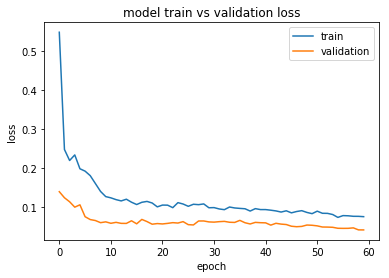

In [20]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

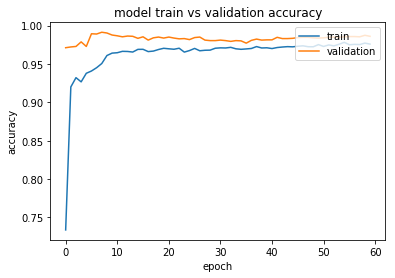

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### 3.3 Predictions

In [22]:
def compare_output(seq_num, model=model, feature=X_test,label=y_test):
    tr=feature[seq_num]
    tl=label[seq_num]
    tr_decoded=decode_label_seq(np.argmax(tr, axis=1))
    print('Input:',tr_decoded)
    print('Label:',tl)
    tp=model.predict(np.array([tr]))
    print('Predicted Label',tp)

In [23]:
compare_output(65)

Input: <0908 kaitlin run apt 959 west james ak 68746>________________________
Label: 1
Predicted Label [[0.99403965]]


In [24]:
compare_output(63)

Input: <itrant statesfrom sistertates which had the>_________________________
Label: 0
Predicted Label [[0.0013903]]


In [25]:
def test_acc(features=X_test, labels=y_test, model=model, threshold=0.5):
    predictions=model.predict(features).reshape((-1))
    predictions=np.array(predictions>threshold).astype(np.int)
    acc=accuracy_score(labels, predictions)
    return acc

In [65]:
thresholds=np.array(range(90,100,1))/100

In [66]:
acc=[]
for th in thresholds:
    acc.append(test_acc(threshold=th))


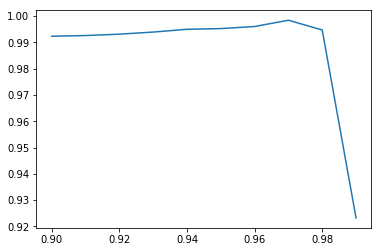

In [67]:
plt.plot(thresholds,acc)

In [27]:
def get_probabilities(data_df=data_df,model=model, input_data_col='Seq'):
    encoder_inp_integer=data_df[input_data_col].apply(lambda l:encode_label_seq(l))
    
    X = pad_sequences(encoder_inp_integer, maxlen=70, padding='post')
    X = onehot_encode_matrix(X)
    prob=model.predict(np.array(X)).reshape((-1))
    data_df['Prob']=prob
    return data_df

In [28]:
data_df=get_probabilities(data_df)

In [68]:
labels=np.array(data_df['Label'])
probabilties=np.array(data_df['Prob'])
threshold=0.97
predictions=np.array(probabilties>threshold).astype(np.int)
data_df['Predicted']=predictions

In [69]:
data_df[data_df['Label']!=data_df['Predicted']].head()

,Seq,Label,Prob,Predicted
10820,365 for FinancialsMicrosoft Dynamics 365 Servi...,0,0.973457,1
11218,7002ode of PracticeSO 27018ode of Practice,0,0.975402,1
12627,p 73 2CW 59230nlawful detainer defined tenant ...,0,0.978153,1
12708,2019 c 356 21998 c 276 61983 c 264 11953 c 106...,0,0.997142,1
12709,or1905 c 86 11891 c 96 31890 p 73 3RR,0,0.992007,1
12710,S 812OTESntent019 c 356t is,0,0.981955,1
12733,019 c 356 1ermination of month to month tenanc...,0,0.972399,1
12734,5942059800nlawful detainer definedR,0,0.982024,1
12740,02009 c 292 11CW 59235olding over on agr,0,0.991484,1
12760,59460CW 59240ervice of noticeroof of serviceny...,0,0.981162,1


(array([8.5540e+03, 1.7000e+01, 1.8000e+01, 9.0000e+00, 1.8000e+01,
        2.5000e+01, 3.5000e+01, 3.2000e+01, 5.3000e+01, 1.0128e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

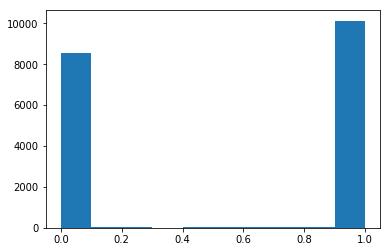

In [31]:
plt.hist(np.round(data_df['Prob'],2))

In [32]:
data_df[(data_df['Prob']>0.5) & (data_df['Prob']<0.8)].head()

,Seq,Label,Prob,Predicted
10228,roductioneginning July 12014 these Online Service,0,0.689871,1
10317,ocated at httpoicrosoftominkid839207perating S...,0,0.595089,1
10364,in a limited function account for 90,0,0.764688,1
10626,the Family Educational Rights and Privacy Act20,0,0.575457,1
10653,terms are defined in 45 CFR 16003execution of ...,0,0.529227,1
10763,sion Decision of 5 February 2010 on sta,0,0.575738,1
10801,n under European Commission 20107U f Februa,0,0.666422,1
10818,s 365 Core Services do not include Micros,0,0.525479,1
11217,n in the table belownline ServiceSO 27001SO 2,0,0.720696,1
11445,icrosoftomwlinkinkID29046recedencehis Microso,0,0.720219,1
